# EDA

- Histograms sanity check
- Representatives from each group
- Aggregation of the data by Ilan's lab
  - See if improves reprentatives
- Heirechical Clustering
- Supervised classification

In [172]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats
from preprocessing import *
from config import *
np.random.seed(42)

### Load data

In [130]:
track_length = 32

In [173]:
v_size = len(np.where(np.isin(y,['D2']))[0])

(713,)

In [178]:
y = np.load(rf'data_files\labels_All{track_length}.npy')
y = y[np.where(~np.isin(y,['D3','G5','G6']))]
y.shape

(3897,)

In [232]:
idx = np.random.choice(np.where(np.isin(y,['D2']))[0],replace=False,size = v_size//2)
y_balanced = np.delete(y,idx)
y_balanced.shape

(3184,)

In [235]:
x.shape

(3897, 32, 5)

In [237]:
x = np.load(rf'data_files\features_All{track_length}.npy')
x = x[np.where(~np.isin(y,['D3','G5','G6']))]
x_balanced = np.delete(x,idx,axis = 0)
x_balanced.shape

(3184, 32, 5)

In [153]:
x_re = x.reshape(-1, x.shape[-1])
x_re.shape

(124704, 5)

## Histograms

### Latitude, Longtitude

<AxesSubplot:>

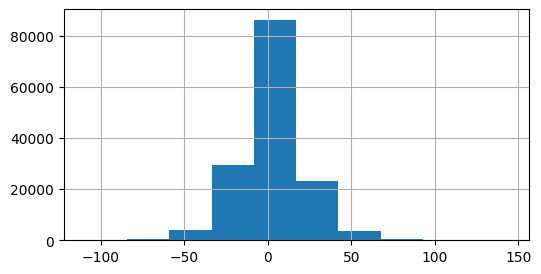

In [44]:
pd.Series(x_re[:,0]).hist(figsize = (6,3))

<AxesSubplot:>

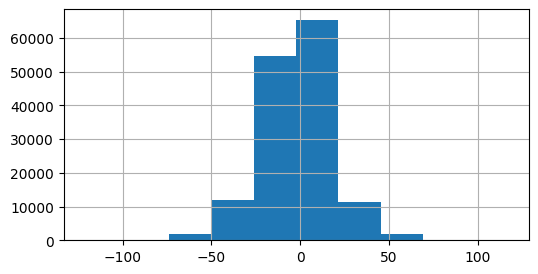

In [45]:
pd.Series(x_re[:,1]).hist(figsize = (6,3))

### Area

<AxesSubplot:>

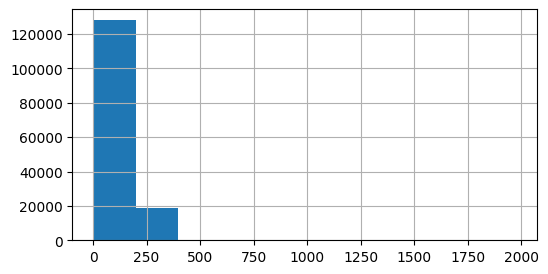

In [46]:
pd.Series(x_re[:,2]).hist(figsize = (6,3))

In [27]:
pd.Series(x_re[:,2]).describe()

count    147200.000000
mean        150.136902
std          52.307520
min           2.000000
25%         117.000000
50%         140.000000
75%         172.000000
max        1977.000000
dtype: float64

### Major Axis, Minor Axis

<AxesSubplot:>

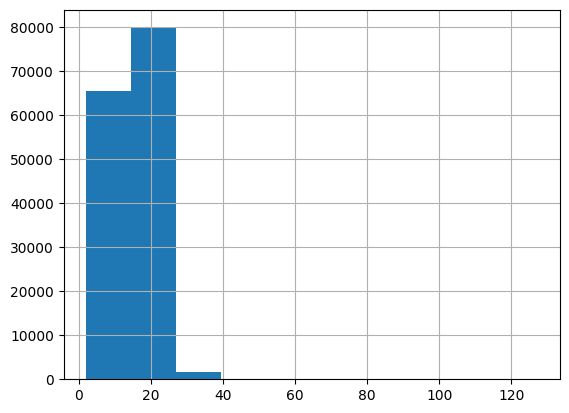

In [22]:
pd.Series(x_re[:,3]).hist()

<AxesSubplot:>

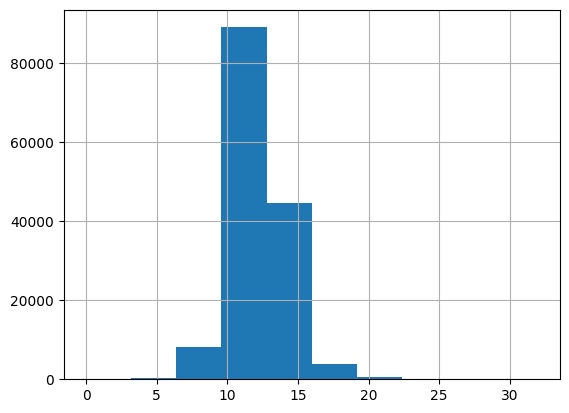

In [23]:
pd.Series(x_re[:,4]).hist()

## Normalize

In [155]:
scaler = StandardScaler()
x_norm = scaler.fit_transform(x.reshape(-1, x.shape[-1])).reshape(x.shape)
x_norm.shape

(3897, 32, 5)

In [156]:
no_outliers_idx = idx_no_outliers_after_norm(x_norm)
x_norm_no_out = x_norm[no_outliers_idx]
x_norm_no_out.shape

(3864, 32, 5)

In [157]:
x_norm_no_out_re = x_norm_no_out.reshape(-1, x_norm_no_out.shape[-1])
x_norm_no_out_re.shape

(123648, 5)

### Histograms

<AxesSubplot:>

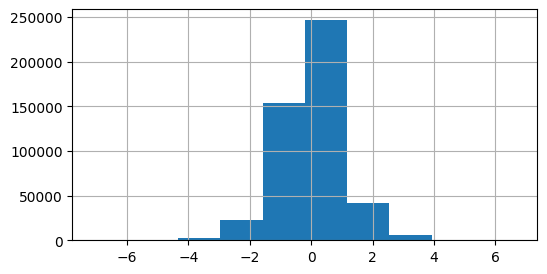

In [105]:
pd.Series(x_norm_no_out_re[:,0]).hist(figsize = (6,3))

<AxesSubplot:>

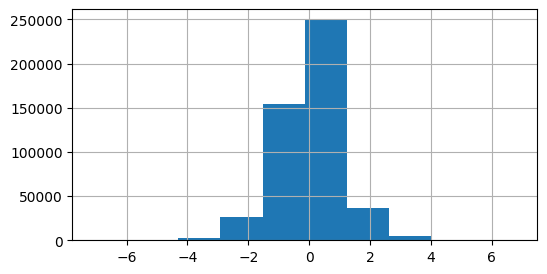

In [106]:
pd.Series(x_norm_no_out_re[:,1]).hist(figsize = (6,3))

<AxesSubplot:>

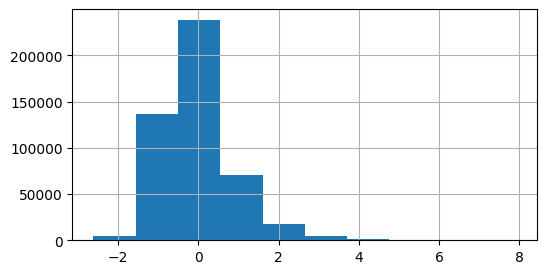

In [107]:
pd.Series(x_norm_no_out_re[:,2]).hist(figsize = (6,3))

<AxesSubplot:>

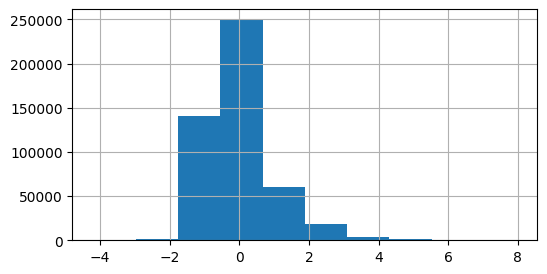

In [108]:
pd.Series(x_norm_no_out_re[:,3]).hist(figsize = (6,3))

<AxesSubplot:>

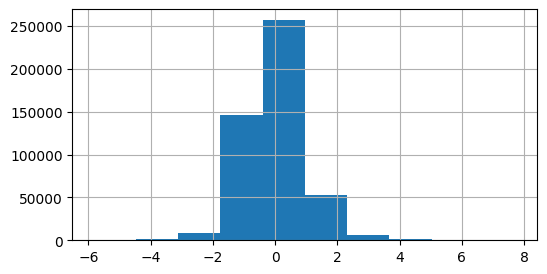

In [109]:
pd.Series(x_norm_no_out_re[:,4]).hist(figsize = (6,3))

## Label distribution

- Well distribution

In [154]:
y.shape

(3897,)

In [233]:
y_no_out = y[no_outliers_idx]
y_no_out.shape

(3864,)

<AxesSubplot:>

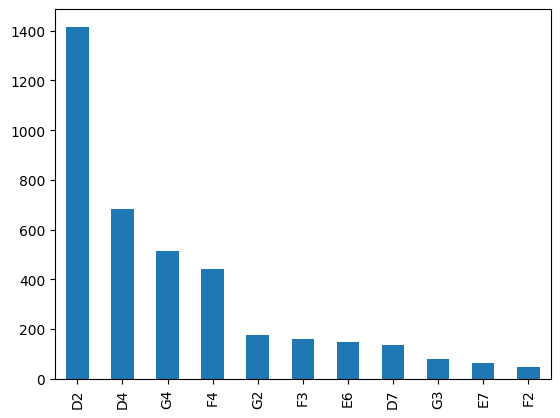

In [159]:
pd.Series(y_no_out).value_counts().plot.bar()

In [240]:
pd.Series(y_balanced).value_counts()

D2    714
D4    687
G4    519
F4    446
G2    178
F3    159
E6    148
D7    137
G3     85
E7     62
F2     49
dtype: int64

In [238]:
y2treat = pd.Series(y_balanced).map(wells_to_genetype_dict)

<AxesSubplot:>

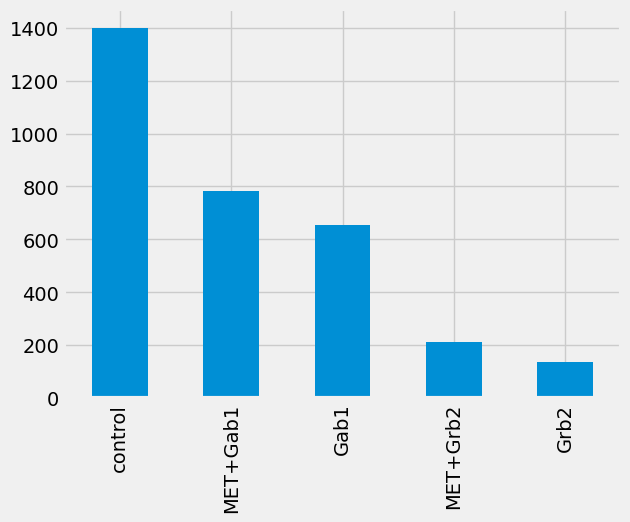

In [239]:
y2treat.value_counts().plot.bar()

## Data Transformation

In [180]:
X_train = x_norm_no_out.copy()
traj = X_train[:,:,:2]
traj.shape

(3864, 32, 2)

In [185]:
from preprocessing import *

def spheroid(long_sq,short_sq):
    return np.sqrt((long_sq-short_sq)/long_sq) if long_sq!=short_sq else 0
def elip(majorminor):
    maj_sq = majorminor[0]**2
    min_sq = majorminor[1]**2
    return spheroid(maj_sq,min_sq) if maj_sq>min_sq else spheroid(min_sq,maj_sq)

def getAngleRad(diffs):
    return np.arctan2(diffs[1], diffs[0])
def getAngleRadZero(xy):
    return np.arctan2(xy[1]-0, xy[0]-0)

def add_transformations(X_train):
    #ellipticity
    ellipticity = np.apply_along_axis(elip, 2, X_train[:,:,3:5])
    X_train = np.dstack((X_train,ellipticity))
    #step size
    d = np.diff(X_train[:,:,:2],axis=1,prepend=0)
    step_size = np.sqrt(np.power(d,2).sum(axis=2))
    X_train = np.dstack((X_train,step_size))
    #displacement
    displacement = np.sum(X_train[:,:,:2]**2,axis=2)
    X_train = np.dstack((X_train,displacement))
    #acceleration
    acceleration = np.diff(step_size,axis=1,prepend=0)/30.0
    X_train = np.dstack((X_train,acceleration))
    #angle of step
    d = np.diff(X_train[:,:,:2],axis=1,prepend=0)
    angles_of_step = np.apply_along_axis(getAngleRad, 2, d)
    X_train = np.dstack((X_train,angles_of_step))
    #angle from center
    angles_from_center = np.apply_along_axis(getAngleRad, 2, X_train[:,:,:2])
    X_train = np.dstack((X_train,angles_from_center))

    return X_train

In [187]:
X_transform = add_transformations(X_train)
X_transform.shape

(3864, 32, 11)

In [117]:
# from tslearn.clustering import TimeSeriesKMeans
# n_clusters = 4

# model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=10)
# model.fit(displacement)
# pd.Series(model.predict(displacement)).value_counts()
# y_pred = model.predict(displacement)
# y_pred.shape

TimeSeriesKMeans(max_iter=10, metric='dtw', n_clusters=4)

In [196]:
m = np.expand_dims(np.mean(X_transform,axis=1),-1)
s = np.expand_dims(np.std(X_transform,axis=1),-1)
x_k = np.concatenate((s,m),axis = 2)
x_k = x_k.reshape(x_k.shape[0],-1)
x_k.shape

(3864, 22)

In [198]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(x_k)
    sse.append(kmeans.inertia_)

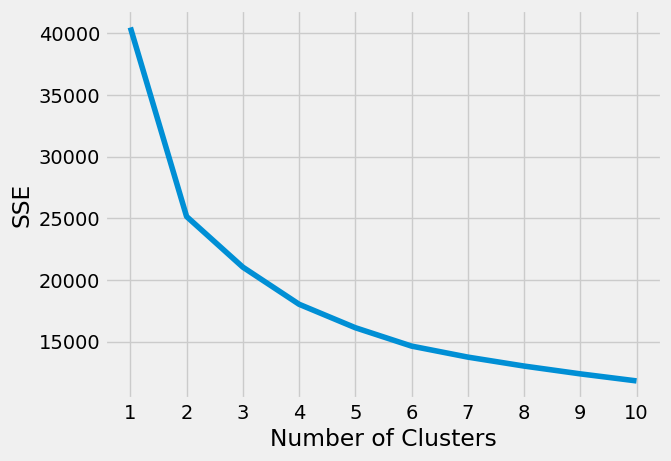

In [199]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

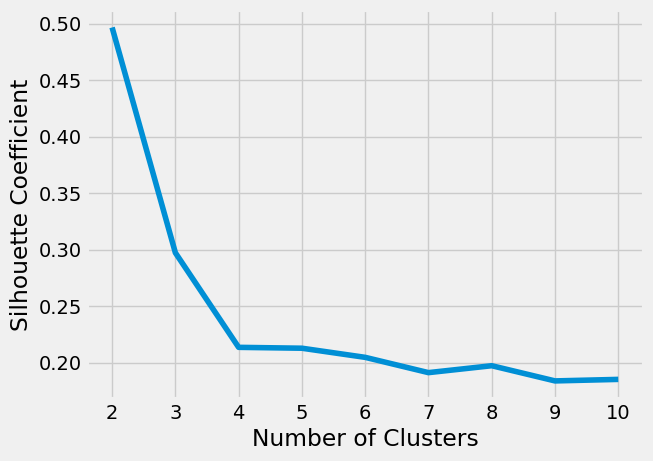

In [204]:
from sklearn.metrics import silhouette_score
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(x_k)
    score = silhouette_score(x_k, kmeans.labels_)
    silhouette_coefficients.append(score)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [208]:
from sklearn.cluster import DBSCAN
kmeans = KMeans(n_clusters=2)
dbscan = DBSCAN(eps=0.8)

# Fit the algorithms to the features
kmeans.fit(x_k)
dbscan.fit(x_k)

# Compute the silhouette scores for each algorithm
kmeans_silhouette = silhouette_score(
    x_k, kmeans.labels_
).round(2)
dbscan_silhouette = silhouette_score(
   x_k, dbscan.labels_
).round (2)

In [210]:
dbscan_silhouette

0.5

In [213]:
pd.Series(kmeans.predict(x_k)).value_counts()

0    3283
1     581
dtype: int64

In [215]:
kmeans = KMeans(n_clusters=4, **kmeans_kwargs)
kmeans.fit(x_k)
kmeans.transform(x_k)

array([[ 9.95971626,  0.86750367,  2.16156337,  4.424218  ],
       [ 9.63482274,  1.96244106,  1.09039581,  4.05211282],
       [ 8.87576603,  1.25524824,  2.40195693,  3.47754885],
       ...,
       [ 9.56227523,  2.69319948,  1.28966078,  4.2431077 ],
       [10.32369278,  2.34686036,  1.88527054,  4.77623361],
       [ 9.63127792,  2.54424349,  0.71106874,  4.15485119]])

In [120]:
import matplotlib.pyplot as plt

def plot_representatives(rep_groups,figsize = (10,20)):
    l = len(rep_groups[0])
    L = len(rep_groups)
    fig, axs = plt.subplots(l,L, figsize=figsize,sharey=True,sharex=True)
    fig.tight_layout()
    for j,reps in enumerate(rep_groups):
        for i,rep in enumerate(reps):
            axs[i,j].plot(rep[:,0],rep[:,1])
    fig.show()

In [183]:
rep_list = []
size = 20
for i in range(n_clusters):
  cluster_vec = x_norm_no_out[np.where(np.isin(y_pred,[i]))]
  cluster_list = cluster_vec[np.random.choice(cluster_vec.shape[0], size, replace=False)]
  rep_list.append(cluster_list)

plot_representatives(rep_list,figsize = (10,40))

IndexError: index 3879 is out of bounds for axis 0 with size 3864

In [16]:
neut1 = ['D2','D3','D4']
neut2 = ['G5','G6','G7']
gab1 = ['F2','F3','F4']
gab1_met = ['G2','G3','G4']
grb2 = ['D5','D6','D7']
grb2_met = ['E5','E6','E7']

c:\Projects\TAU\DL-Workshop\Git Folder\Env\dl_work_mod\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2634 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


<AxesSubplot:>

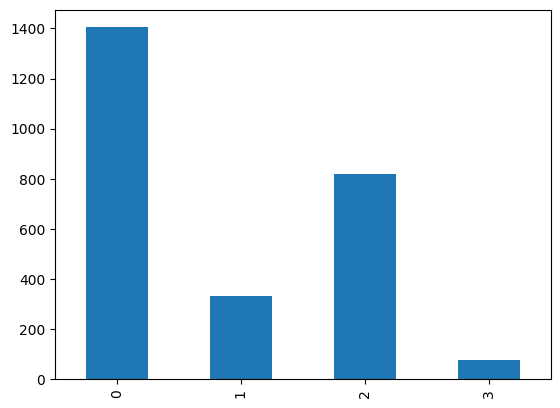

In [94]:
treat_well = model.predict(displacement[np.where(np.isin(y_no_out,neut1))])
pd.Series(treat_well).value_counts().sort_index().plot.bar()

c:\Projects\TAU\DL-Workshop\Git Folder\Env\dl_work_mod\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 780 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


<AxesSubplot:>

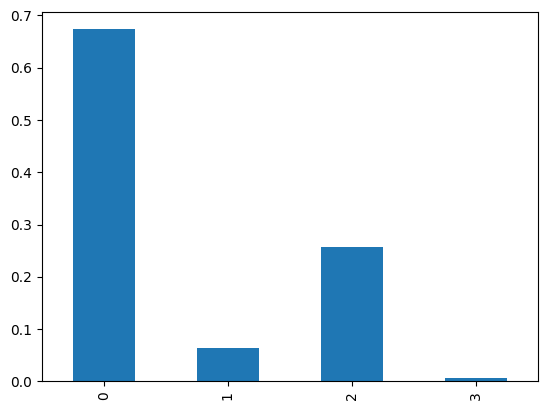

In [91]:
treat_well = model.predict(displacement[np.where(np.isin(y_no_out,gab1_met))])
pd.Series(treat_well).value_counts(normalize=True).sort_index().plot.bar()

c:\Projects\TAU\DL-Workshop\Git Folder\Env\dl_work_mod\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 209 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


<AxesSubplot:>

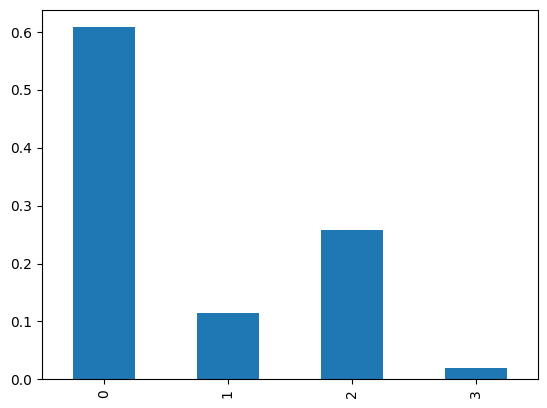

In [90]:
treat_well = model.predict(displacement[np.where(np.isin(y_no_out,grb2_met))])
pd.Series(treat_well).value_counts(normalize=True).sort_index().plot.bar()

c:\Projects\TAU\DL-Workshop\Git Folder\Env\dl_work_mod\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 651 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


<AxesSubplot:>

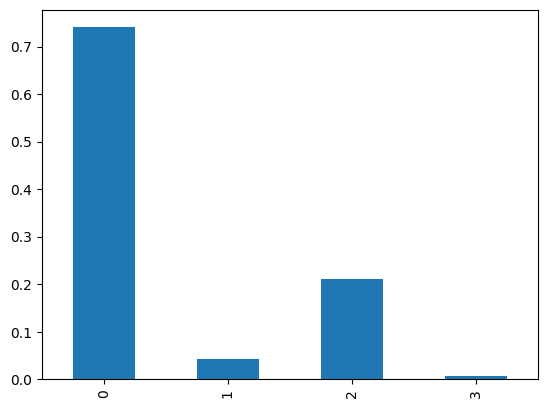

In [89]:
treat_well = model.predict(displacement[np.where(np.isin(y_no_out,gab1))])
pd.Series(treat_well).value_counts(normalize=True).sort_index().plot.bar()

c:\Projects\TAU\DL-Workshop\Git Folder\Env\dl_work_mod\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 136 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


<AxesSubplot:>

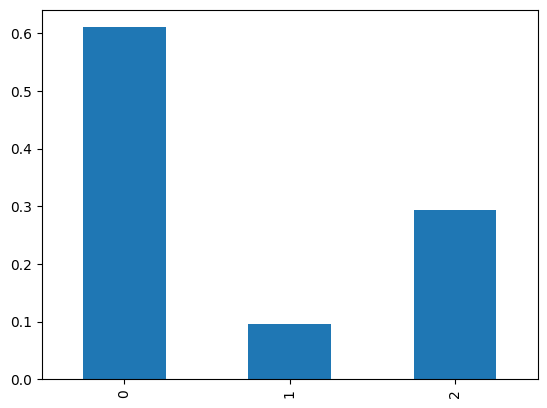

In [88]:
treat_well = model.predict(displacement[np.where(np.isin(y_no_out,grb2))])
pd.Series(treat_well).value_counts(normalize=True).sort_index().plot.bar()

## Representatives

In [ ]:
rep_list = []
size = 10
for i in range(n_clusters):
  cluster_vec = x[np.where(np.isin(y_pred,[i]))]
  cluster_list = cluster_vec[np.random.choice(cluster_vec.shape[0], size, replace=False)]
  rep_list.append(cluster_list)

plot_representatives(rep_list,figsize = (10,20))

In [45]:
# x_s = np.array([[[0,0],[2,2],[2,2]] , [[0,0],[1,1],[2,2]] ,[[0,0],[3,3],[2,2]]])
# x_s